<a href="https://colab.research.google.com/github/Aryamuda/BTC-Spread-Arbitrage-/blob/main/BTC_SPREAD_ARBITRAGE_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Initial Setup

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

#  Defining Global Parameters

In [2]:
TICKERS = ['BTC-USD', 'BTC-EUR', 'EURUSD=X', 'DX-Y.NYB'] # Pairs
PERIODE_DATA = '5y'

ROLLING_WINDOW = 90  # Time period for mean and stdev
ENTRY_THRESHOLD = 1.5 # Stdev

# Backtest Simulation
INITIAL_CAPITAL = 100000  # Initial capital for the backtest simulation
TRANSACTION_COST = 0.001 # Estimated transaction cost

# Core Strategy and Backtesting Functions

In [4]:
# Fetching Data and taking the close column only
def fetch_and_prepare_data(tickers, period):
    data = yf.download(tickers, period=period, progress=False)
    close_prices = data['Close'].copy()
    close_prices.dropna(inplace=True)
    return close_prices

# Metrics Analytic
def calculate_analytics(df, window):
    analytics_df = pd.DataFrame(index=df.index)

    # Main Metrics
    analytics_df['Implied_EURUSD_Rate'] = df['BTC-USD'] / df['BTC-EUR']
    analytics_df['Actual_EURUSD_Rate'] = df['EURUSD=X']
    analytics_df['Spread'] = analytics_df['Implied_EURUSD_Rate'] - analytics_df['Actual_EURUSD_Rate']
    analytics_df['DXY_Close'] = df['DX-Y.NYB']

    # Metrics for Strategy
    rolling_mean = analytics_df['Spread'].rolling(window=window).mean()
    rolling_std = analytics_df['Spread'].rolling(window=window).std()
    analytics_df['Upper_Band'] = rolling_mean + (rolling_std * ENTRY_THRESHOLD)
    analytics_df['Lower_Band'] = rolling_mean - (rolling_std * ENTRY_THRESHOLD)

    analytics_df.dropna(inplace=True)
    return analytics_df

# Signal based on spread given bands
def generate_signals(df):
    signals_df = df.copy()
    signals_df['Signal'] = 0
    signals_df.loc[signals_df['Spread'] > signals_df['Upper_Band'], 'Signal'] = -1 # Short Spread
    signals_df.loc[signals_df['Spread'] < signals_df['Lower_Band'], 'Signal'] = 1  # Long Spread
    # Calculate Position (1, -1, atau 0). ffill() For hold.
    signals_df['Position'] = signals_df['Signal'].replace(to_replace=0, method='ffill')
    return signals_df

# Backtest and calculating PNL
def run_backtest(df, transaction_cost):
    backtest_df = df.copy()

    # Daily Return
    daily_spread_return = backtest_df['Spread'].diff()

    # Strategy Return
    backtest_df['Strategy_Return'] = backtest_df['Position'].shift(1) * daily_spread_return

    # Transaction Cost
    trades = backtest_df['Position'].diff().abs()
    backtest_df['Transaction_Cost'] = trades * transaction_cost
    backtest_df['Strategy_Return_Net'] = backtest_df['Strategy_Return'] - backtest_df['Transaction_Cost']

    # Calculate Cumulative Return
    backtest_df['Cumulative_Return'] = (1 + backtest_df['Strategy_Return_Net']).cumprod()
    return backtest_df

# Performance
def calculate_performance_metrics(returns):
    metrics = {}

    # Sharpe Ratio
    sharpe_ratio = returns.mean() / returns.std()
    metrics['Annualized_Sharpe_Ratio'] = sharpe_ratio * np.sqrt(252) # 252 Trading Days in a year

    # Maximum Drawdown
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1
    metrics['Max_Drawdown'] = drawdown.min()

    # Win Rate
    metrics['Win_Rate'] = (returns > 0).sum() / (returns != 0).sum()

    return metrics

#  Strategy Execution and Initial Results

In [6]:
# 1. Take and Prepare the data
price_data = fetch_and_prepare_data(TICKERS, PERIODE_DATA)

# 2. Calculate Metrix
analytics_data = calculate_analytics(price_data, ROLLING_WINDOW)

# 3. Signal
signals_data = generate_signals(analytics_data)

# 4. Backtest
final_results = run_backtest(signals_data, TRANSACTION_COST)

# 5. Performance Metrix
performance = calculate_performance_metrics(final_results['Strategy_Return_Net'])

# Result
display(final_results.tail())

<ipython-input-4-f3297c52a63c>:34: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  signals_df['Position'] = signals_df['Signal'].replace(to_replace=0, method='ffill')


,Implied_EURUSD_Rate,Actual_EURUSD_Rate,Spread,DXY_Close,Upper_Band,Lower_Band,Signal,Position,Strategy_Return,Transaction_Cost,Strategy_Return_Net,Cumulative_Return
Date,,,,,,,,,,,,
2025-06-03,1.140487,1.145344,-0.004858,99.250000,0.044703,-0.041687,0,1,-0.007309,0.0,-0.007309,53.256168
2025-06-04,1.130854,1.138446,-0.007592,98.790001,0.044532,-0.041875,0,1,-0.002734,0.0,-0.002734,53.110545
2025-06-05,1.107681,1.142204,-0.034523,98.739998,0.044572,-0.042547,0,1,-0.026931,0.0,-0.026931,51.680215
2025-06-06,1.177046,1.145383,0.031663,99.190002,0.045259,-0.042342,0,1,0.066186,0.0,0.066186,55.100722
2025-06-09,1.142422,1.142727,-0.000304,98.907997,0.044835,-0.042464,0,1,-0.031967,0.0,-0.031967,53.339323


# Visualizing Strategy Performance

In [14]:
# Display Performance Metrics
print(f"Annualized Sharpe Ratio: {performance['Annualized_Sharpe_Ratio']:.2f}")
print(f"Maximum Drawdown: {performance['Max_Drawdown']:.2%}")
print(f"Win Rate: {performance['Win_Rate']:.2%}")

Annualized Sharpe Ratio: 1.96
Maximum Drawdown: -16.94%
Win Rate: 55.74%


In [43]:
final_results

,Implied_EURUSD_Rate,Actual_EURUSD_Rate,Spread,DXY_Close,Upper_Band,Lower_Band,Signal,Position,Strategy_Return,Transaction_Cost,Strategy_Return_Net,Cumulative_Return
Date,,,,,,,,,,,,
2020-10-14,1.174470,1.174219,0.000251,93.379997,0.007822,-0.007028,0,0,NaN,NaN,NaN,NaN
2020-10-15,1.170670,1.174398,-0.003729,93.860001,0.007768,-0.007118,0,0,-0.000000,0.0,-0.000000,1.000000
2020-10-16,1.171646,1.170713,0.000933,93.680000,0.007725,-0.007130,0,0,0.000000,0.0,0.000000,1.000000
2020-10-19,1.176844,1.171550,0.005294,93.430000,0.007800,-0.006916,0,0,0.000000,0.0,0.000000,1.000000
2020-10-20,1.182897,1.176886,0.006011,93.070000,0.007931,-0.006845,0,0,0.000000,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03,1.140487,1.145344,-0.004858,99.250000,0.044703,-0.041687,0,1,-0.007309,0.0,-0.007309,53.256168
2025-06-04,1.130854,1.138446,-0.007592,98.790001,0.044532,-0.041875,0,1,-0.002734,0.0,-0.002734,53.110545
2025-06-05,1.107681,1.142204,-0.034523,98.739998,0.044572,-0.042547,0,1,-0.026931,0.0,-0.026931,51.680215


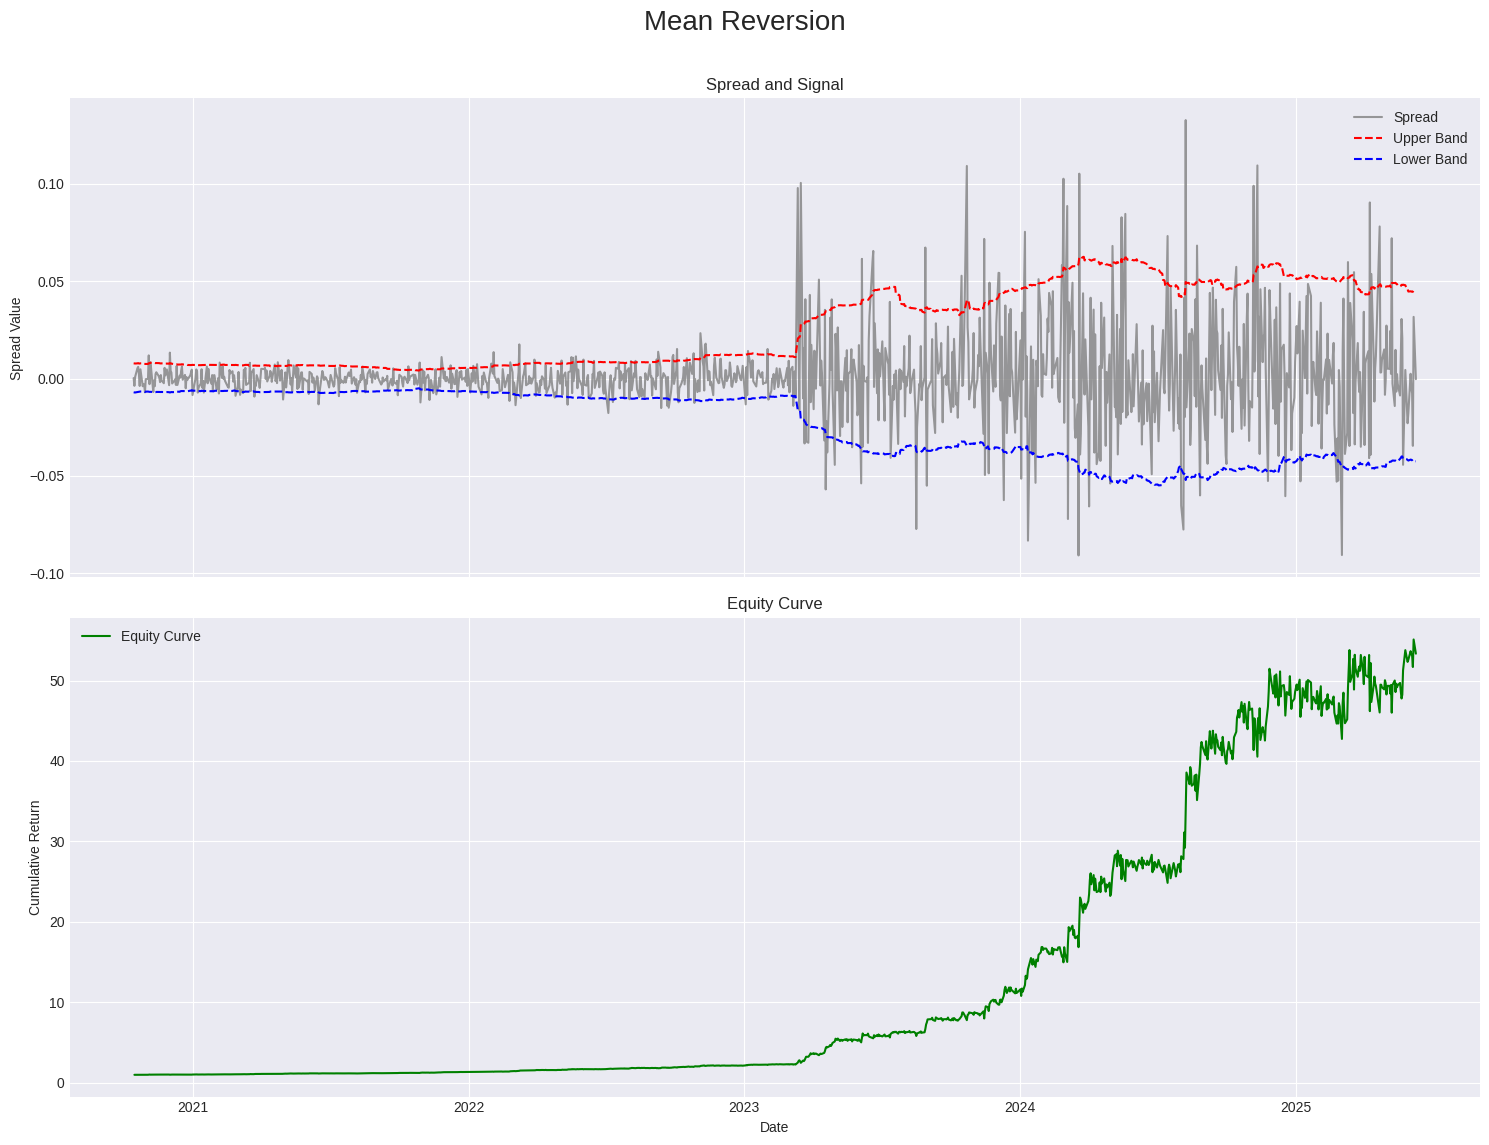

In [17]:
# Visualize Result
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharex=True)
fig.suptitle('Mean Reversion', fontsize=20)

# Plot 1: Spread And Trading Bands
ax1.plot(final_results.index, final_results['Spread'], label='Spread', color='gray', alpha=0.8)
ax1.plot(final_results.index, final_results['Upper_Band'], label='Upper Band', color='red', linestyle='--')
ax1.plot(final_results.index, final_results['Lower_Band'], label='Lower Band', color='blue', linestyle='--')
ax1.set_title('Spread and Signal')
ax1.set_ylabel('Spread Value')
ax1.legend()

# Plot 2: Equity Curve
ax2.plot(final_results.index, final_results['Cumulative_Return'], label='Equity Curve', color='green')
ax2.set_title('Equity Curve')
ax2.set_ylabel('Cumulative Return')
ax2.set_xlabel('Date')
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Statistical Validation of Mean Reversion (Stationarity Tests)

In [40]:
from statsmodels.tsa.stattools import adfuller, kpss

# Spread data from the final results DataFrame.
spread_series = final_results['Spread'].dropna()

# Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(spread_series)
adf_statistic = adf_result[0]
adf_pvalue = adf_result[1]
adf_crit_values = adf_result[4]

print(f'ADF Statistic: {adf_statistic:.4f}')
print(f'P-value: {adf_pvalue:.4f}')
print('Critical Values:')
for key, value in adf_crit_values.items():
    print(f'\t{key}: {value:.4f}')

# Interpret the ADF test result.
if adf_pvalue < 0.05 and adf_statistic < adf_crit_values['5%']:
    print(">> The 'Spread' series is likely STATIONARY.")
else:
    print(">> The 'Spread' series is likely NON-STATIONARY.")

print("\n" + "="*50 + "\n")

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

kpss_result = kpss(spread_series, regression='c', nlags="auto")
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_crit_values = kpss_result[3]

print(f'KPSS Statistic: {kpss_statistic:.4f}')
print(f'P-value: {kpss_pvalue:.4f}')
print('Critical Values:')
for key, value in kpss_crit_values.items():
    print(f'\t{key}: {value:.4f}')

# Interpret KPPS test result
if kpss_pvalue < 0.05 and kpss_statistic < kpss_crit_values['5%']:
    print(">> The 'Spread' series is likely STATIONARY.")
else:
    print(">> The 'Spread' series is likely NON-STATIONARY. ")

ADF Statistic: -6.3545
P-value: 0.0000
Critical Values:
	1%: -3.4361
	5%: -2.8641
	10%: -2.5681
>> The 'Spread' series is likely STATIONARY.


KPSS Statistic: 0.5758
P-value: 0.0248
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
>> The 'Spread' series is likely NON-STATIONARY. 


# Regime Change Analysis: Validating Stationarity on Recent Data

In [41]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

# Split date that separates the two market regimes.
split_date = '2023-06-01'

# Data Preparation
data_after_split = final_results.loc[split_date:].copy()

# Extract the 'Spread' series from this recent data and drop any NaNs.
spread_series_after_split = data_after_split['Spread'].dropna()


# Augmented Dickey-Fuller (ADF) Test on Splitted Data
adf_result_after = adfuller(spread_series_after_split)
adf_pvalue_after = adf_result_after[1]

print(f'P-value: {adf_pvalue_after:.4f}')

# Interpret the ADF result
if adf_pvalue_after < 0.05:
    print(">> The 'Spread' is likely STATIONARY.")
else:
    print(">> The 'Spread' is likely NON-STATIONARY.")

print("\n" + "="*50 + "\n")


# Kwiatkowski-Phillips-Schmidt-Shin KPSS Test on Splitted Data
kpss_result_after = kpss(spread_series_after_split, regression='c', nlags="auto")
kpss_pvalue_after = kpss_result_after[1]

print(f'P-value: {kpss_pvalue_after:.4f}')

# Interpret the result based on the p-value.
if kpss_pvalue_after > 0.05:
    print(">>The 'Spread' is likely STATIONARY.")
else:
    print(">> The 'Spread' is likely NON-STATIONARY.")

print("\n" + "="*50 + "\n")

P-value: 0.0000
>> The 'Spread' is likely STATIONARY.


P-value: 0.1000
>>The 'Spread' is likely STATIONARY.




<ipython-input-41-6f22dd75deba>:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_after = kpss(spread_series_after_split, regression='c', nlags="auto")


#  Monte Carlo Simulation for Stress Testing

In [18]:
def run_monte_carlo_simulation(daily_returns, num_simulations, simulation_period_years):

    # Remove any NaN values and convert the returns to a NumPy array.
    clean_returns = daily_returns.dropna().to_numpy()

    # Assume an average of 252 trading days per year.
    trading_days = simulation_period_years * 252

    # Create an empty NumPy array to store the results of all simulations.
    all_simulation_paths = np.zeros((trading_days, num_simulations))

    # Loop through each simulation scenario.
    for i in range(num_simulations):
        simulated_daily_returns = np.random.choice(clean_returns, size=trading_days, replace=True)

        # Calculate the equity curve for this specific simulation (cumulative return).
        simulated_path = (1 + simulated_daily_returns).cumprod()

        # Store the resulting equity curve path in our main array.
        all_simulation_paths[:, i] = simulated_path

    # Convert the results array into a pandas DataFrame for easier analysis and plotting.
    simulation_results_df = pd.DataFrame(all_simulation_paths)

    return simulation_results_df

monte_carlo_results = run_monte_carlo_simulation(
    daily_returns=final_results['Strategy_Return_Net'],
    num_simulations=5000,       # Run 5,000 different scenarios.
    simulation_period_years=2  # Simulate each scenario over a 2-year period.
)

# Display a sample of the final outcomes from the simulation.
print("\nExample of final results from the first 5 scenarios:")
display(monte_carlo_results.iloc[-1, :5])


Example of final results from the first 5 scenarios:


,503
0,11.327774
1,5.691672
2,2.982599
3,9.708915
4,10.569511


# Analyzing and Visualizing Monte Carlo Simulation Results

In [21]:
# Calculate & Display Key Statistics
final_returns = monte_carlo_results.iloc[-1, :]

# Calculate key statistics from the distribution of final returns.
median_return = final_returns.median()
mean_return = final_returns.mean()
percentile_5 = final_returns.quantile(0.05)   # 5% of simulations ended below this value.
percentile_95 = final_returns.quantile(0.95) # 95% of simulations ended below this value.
prob_loss = (final_returns < 1).sum() / len(final_returns) # Probability of the final return being < 1.0x

print("\n--- Key Statistics from 5000 Scenarios (2-Year Period) ---")
print(f"Median Outcome (Middle Case): {median_return:.2f}x")
print(f"Mean Outcome (Average): {mean_return:.2f}x")
print(f"Probability of Loss (Outcome < 1.0x): {prob_loss:.2%}")
print("----------------------------------------------------------------")
print(f"Worst Case (5th Percentile): {percentile_5:.2f}x")
print(f"Best Case (95th Percentile): {percentile_95:.2f}x")
print("----------------------------------------------------------------")


--- Key Statistics from 5000 Scenarios (2-Year Period) ---
Median Outcome (Middle Case): 5.49x
Mean Outcome (Average): 7.18x
Probability of Loss (Outcome < 1.0x): 0.60%
----------------------------------------------------------------
Worst Case (5th Percentile): 1.78x
Best Case (95th Percentile): 18.28x
----------------------------------------------------------------


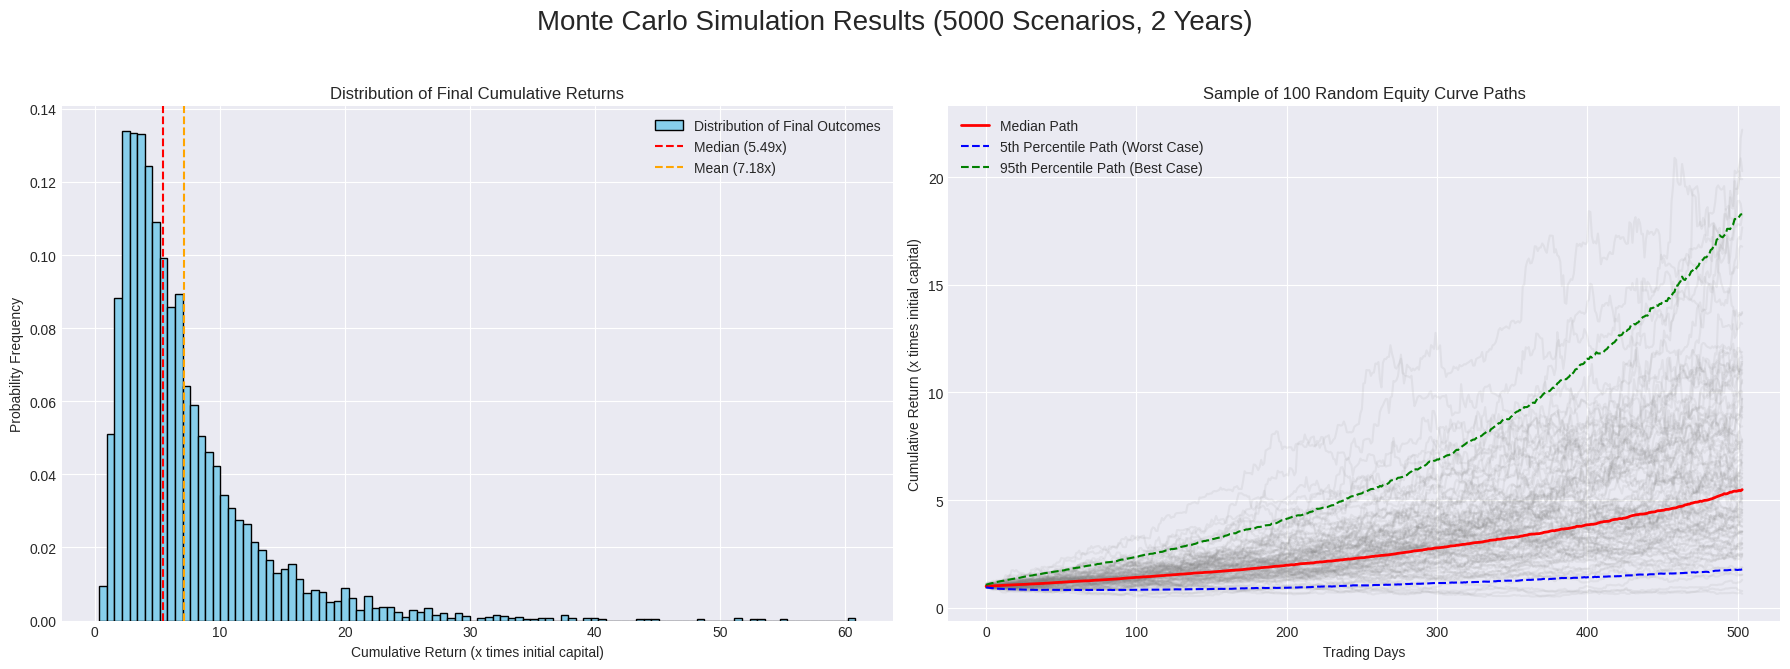

In [22]:
# Distribution Graph (Histogram)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
fig.suptitle('Monte Carlo Simulation Results (5000 Scenarios, 2 Years)', fontsize=20)

# Histogram Plot (ax1)
ax1.hist(final_returns, bins=100, density=True, label='Distribution of Final Outcomes', color='skyblue', edgecolor='black')
ax1.axvline(median_return, color='red', linestyle='--', label=f'Median ({median_return:.2f}x)')
ax1.axvline(mean_return, color='orange', linestyle='--', label=f'Mean ({mean_return:.2f}x)')
ax1.set_title('Distribution of Final Cumulative Returns')
ax1.set_xlabel('Cumulative Return (x times initial capital)')
ax1.set_ylabel('Probability Frequency')
ax1.legend()
ax1.grid(True)


# Equity Curve Paths Graph
num_paths_to_plot = 100 # 100 random paths for cleaner visualization
ax2.plot(monte_carlo_results.index, monte_carlo_results.iloc[:, :num_paths_to_plot], color='gray', alpha=0.1)

# Overlay the key statistical paths for context.
ax2.plot(monte_carlo_results.index, monte_carlo_results.median(axis=1), color='red', linestyle='-', linewidth=2, label='Median Path')
ax2.plot(monte_carlo_results.index, monte_carlo_results.quantile(0.05, axis=1), color='blue', linestyle='--', linewidth=1.5, label='5th Percentile Path (Worst Case)')
ax2.plot(monte_carlo_results.index, monte_carlo_results.quantile(0.95, axis=1), color='green', linestyle='--', linewidth=1.5, label='95th Percentile Path (Best Case)')

ax2.set_title(f'Sample of {num_paths_to_plot} Random Equity Curve Paths')
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Cumulative Return (x times initial capital)')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()